In [1]:
#fig size configuration
figureSize=(6, 4)
dpiValue=150
plotFormat='-o'
markerSize=3

In [2]:
import os
import re
import csv
from itertools import zip_longest

resultsFolder = 'experimental_results'

resList = [['test-case', 'cfg', 'date', 'total_time-time', 
            'total_time-main', 'beta', 'avg-PIs', 'n-PIs', 
            '1st-PI', '2nd-PI', 'avg(2-6)', 'avg(2-11)']]

resDict = {}

if resultsFolder not in os.listdir():
    print(f"ERROR: {resultsFolder} folder not found")
    exit(1)
    
# for each test case
for tc in os.listdir(resultsFolder):
    clusterConf = os.listdir(f"{resultsFolder}/{tc}")
    resDict[tc] = {}
    
    # for each cluster configuration
    for cc in clusterConf:
        resDict[tc][cc] = []
        testDates = os.listdir(f"{resultsFolder}/{tc}/{cc}")
        
        # for each date
        for td in testDates:
            timeOutFile = open(f"{resultsFolder}/{tc}/{cc}/{td}/time.out", "r")
            lmpOutFile  = open(f"{resultsFolder}/{tc}/{cc}/{td}/lmp.out", "r")
            
            # /usr/bin/time command outputs the elapsed walltime 
            # the file contains the time value in seconds
            wallTime = float(timeOutFile.read())
            
            '''
            Parse MO833 profiling info
            '''
            PIavg    = {} # PIavg[0]  = x means process 0 showed PIavg = x
            beta     = {} # beta[0]   = x means process 0 showed beta = x
            parIter  = {} # parIter[x,y] = z is duration of PI y in process x

            for line in lmpOutFile.readlines():
                # remove line break
                line = line.replace('\n','')
                
                if "[MO833] Paramount Iteration" in line:
                    procNum    = float(line.split(',')[1])
                    PInum      = float(line.split(',')[2])
                    duration   = float(line.split(',')[3])
                    parIter[procNum,PInum] = duration
               
                elif "[MO833] Beta" in line:
                    procNum = float(line.split(',')[1])
                    betaVal = float(line.split(',')[2])
                    beta[procNum] = betaVal

                elif "[MO833] PI avg" in line:
                    procNum  = float(line.split(',')[1])
                    PIavgVal = float(line.split(',')[2])
                    PIavg[procNum] = PIavgVal
                
                elif "[MO833] Total time" in line:
                    mainTime = float(line.split(',')[1])

            # close files
            timeOutFile.close()
            lmpOutFile.close()
                    
            nProcs = len(beta)
            nPI    = len([z for ((x,y),z) in parIter.items() if x == 0])

            
            '''
            Print some useful infermation about quality of the data
            '''
            betaDiff  = max(beta.values())-min(beta.values())
            PIavgDiff = max(PIavg.values())-min(PIavg.values())
            timeDiff  = wallTime-mainTime
            
            # for each PI, compute the biggest diff between procs
            diffTimes=[]
            for currPI in set([PI for ((proc,PI),dur) in parIter.items()]):
                currPITimes=[dur for ((proc,PI),dur) in parIter.items() if PI==currPI]
                diffTimes.append(max(currPITimes)-min(currPITimes))

            print(f"========{tc}|{cc}|{td}=============")
            print(f"MaxBeta-MinBeta   ={betaDiff:.5f}")
            print(f"MaxPIavg-MinPIavg ={PIavgDiff:.5f}s")
            print(f"MainTime-WallTime ={timeDiff:.5f}s")
            print(f"BiggestPIProcDiff ={max(diffTimes):.5f}s with {nProcs} procs")
            print("")
            
            # gets PI times at proc 0
            proc0PI = [(dur,PI) for ((proc,PI),dur) in parIter.items()
                   if proc == 0]
            proc0PI.sort(key=lambda tup: tup[1])
            
            # saves PI durations at resDict
            # this data will be plotted on the next cell
            resDict[tc][cc].append([dur for (dur,PI) in proc0PI])
            
            # average duration for par iter from 2 to 6 @ proc 0
            aux = [dur for ((proc,PI),dur) in parIter.items()
                   if proc == 0 and 2 <= PI and PI <= 6]
            avg_2_6  = sum(aux)/len(aux)
            
            # average duration for par iter from 2 to 11 @ proc 0
            aux = [dur for ((proc,PI),dur) in parIter.items()
                   if proc == 0 and 2 <= PI and PI <= 11]
            avg_2_11 = sum(aux)/len(aux)
            
            resList.append([
                tc, #test case
                cc, #cluster configuration
                td, #test dates
                wallTime, #time measured with time
                mainTime, #main function time
                beta[0],
                PIavg[0],
                nPI,
                parIter[0,1], #duration of 1st par it @ proc 0
                parIter[0,2],
                avg_2_6,
                avg_2_11,
            ])

with open('experimental_results.summary.csv', 'w', newline='') as csvSumary:
    wr = csv.writer(csvSumary)
    wr.writerows(resList)

========TC-1|CFG-3|2020-06-25T22:04+00:00=============
MaxBeta-MinBeta   =0.00009
MaxPIavg-MinPIavg =0.00001s
MainTime-WallTime =0.72254s
BiggestPIProcDiff =0.00125s with 8 procs

========TC-1|CFG-3|2020-06-25T20:56+00:00=============
MaxBeta-MinBeta   =0.00010
MaxPIavg-MinPIavg =0.00001s
MainTime-WallTime =1.60920s
BiggestPIProcDiff =0.00955s with 8 procs

========TC-1|CFG-3|2020-06-25T22:03+00:00=============
MaxBeta-MinBeta   =0.00015
MaxPIavg-MinPIavg =0.00001s
MainTime-WallTime =1.12214s
BiggestPIProcDiff =0.00162s with 8 procs

========TC-1|CFG-3|2020-06-25T22:01+00:00=============
MaxBeta-MinBeta   =0.00009
MaxPIavg-MinPIavg =0.00001s
MainTime-WallTime =0.79984s
BiggestPIProcDiff =0.00342s with 8 procs

========TC-1|CFG-3|2020-06-25T22:00+00:00=============
MaxBeta-MinBeta   =0.00009
MaxPIavg-MinPIavg =0.00001s
MainTime-WallTime =1.38688s
BiggestPIProcDiff =0.00206s with 8 procs

========TC-1|CFG-4|2020-06-25T21:11+00:00=============
MaxBeta-MinBeta   =0.00047
MaxPIavg-MinPIavg 

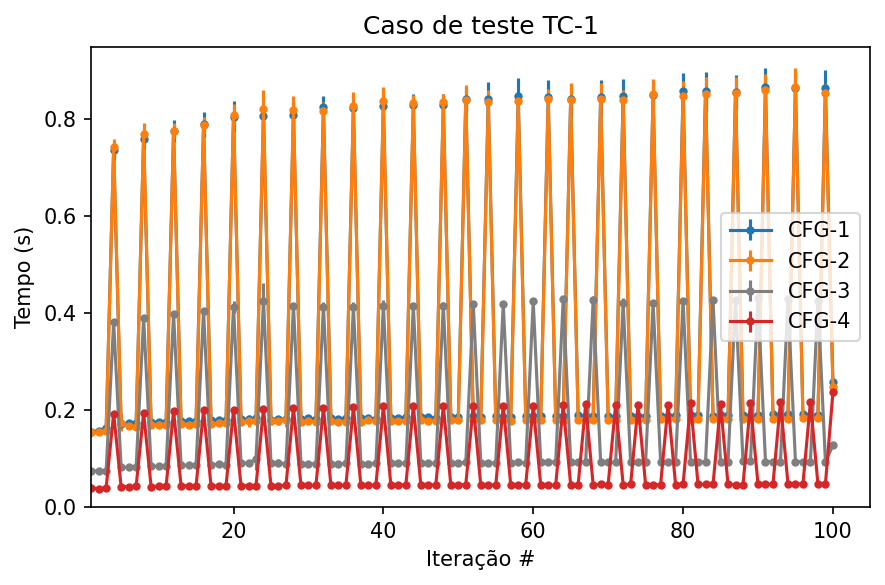

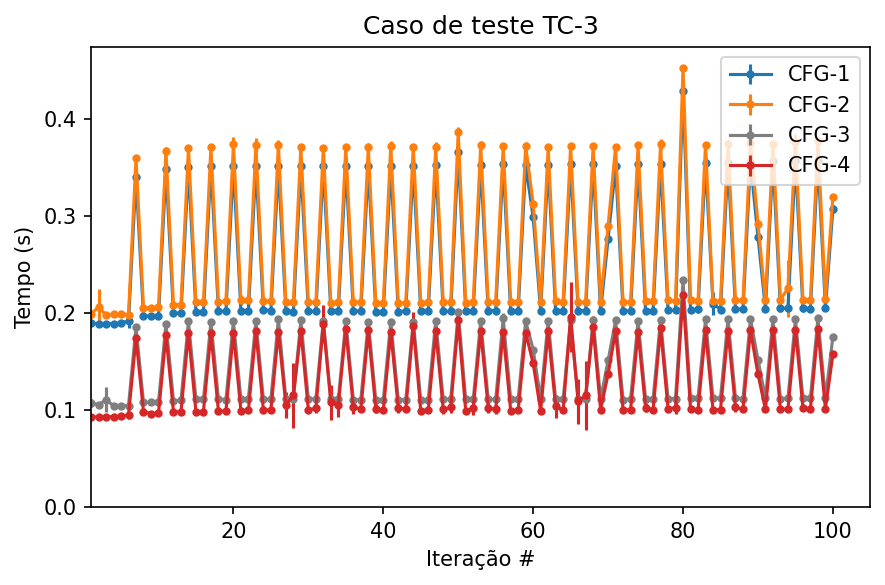

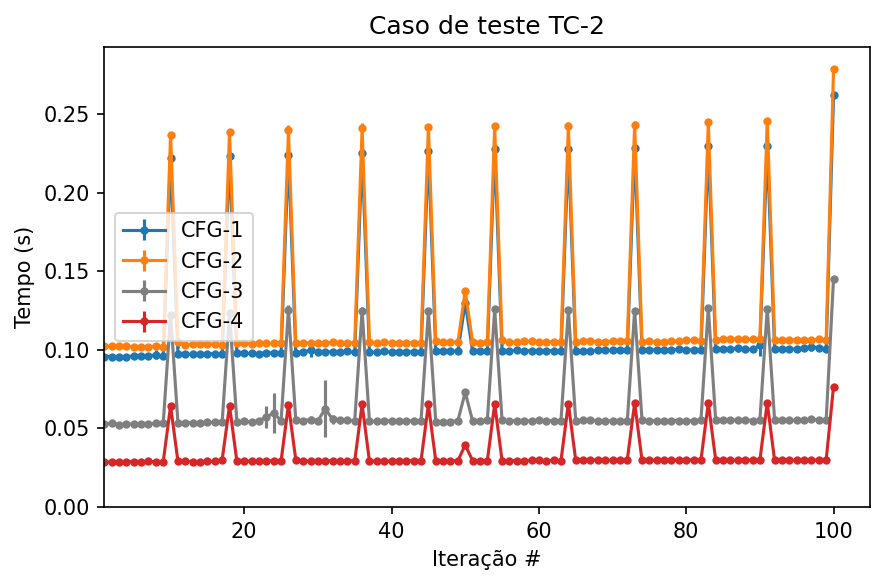

In [3]:
%matplotlib inline

import matplotlib
from statistics import mean,stdev
import matplotlib.pyplot as plt 

lineColor = {
    'CFG-1' :'tab:blue',
    'CFG-2' :'tab:orange',
    'CFG-3' :'tab:gray',
    'CFG-4' :'tab:red',
}

for tc,ccDict in resDict.items():
    plt.figure(figsize=figureSize, dpi = dpiValue, facecolor='w', edgecolor='k')

    for cc in sorted(ccDict):
        piTimes = resDict[tc][cc]
        piMeans = list(map(mean, zip(*piTimes)))
        
        if(len(piTimes) == 0):
            continue
        
        # StdDdev = 0 if there is only one run
        if len(piTimes) > 1:
            piStdDev= list(map(stdev, zip(*piTimes)))
            
        else:
            piStdDev=[0]*len(piTimes[0])
    
        xValues=range(1, len(piTimes[0])+1)
        plt.errorbar(xValues, piMeans, label=f"{cc}", yerr=piStdDev, 
                     fmt=plotFormat, ecolor=lineColor[cc], c=lineColor[cc],
                     markersize=markerSize)
        

    plt.ylabel("Tempo (s)");
    plt.xlabel("Iteração #");
    plt.ylim(0)
    plt.xlim(1)
    plt.title(f"Caso de teste {tc}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'graphs/pi_time_{tc}.pdf') 
    plt.show()
   


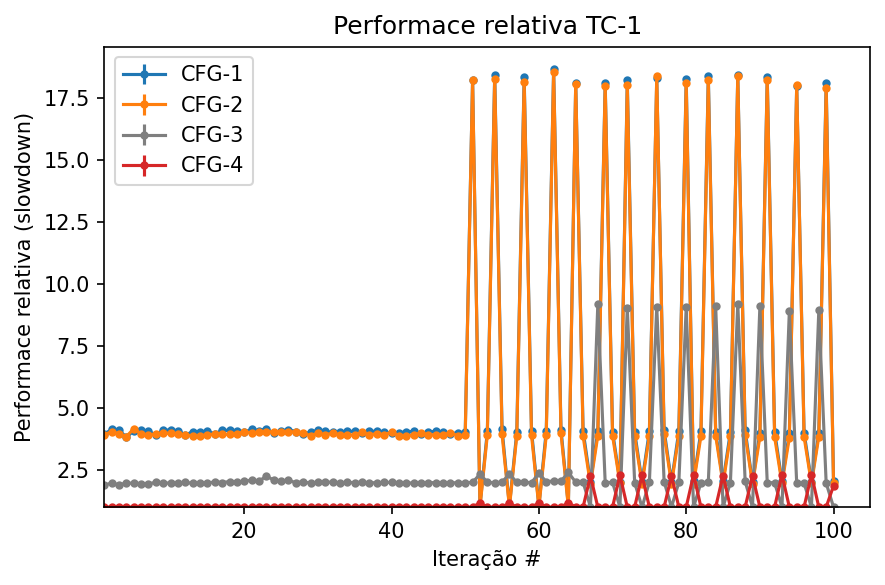

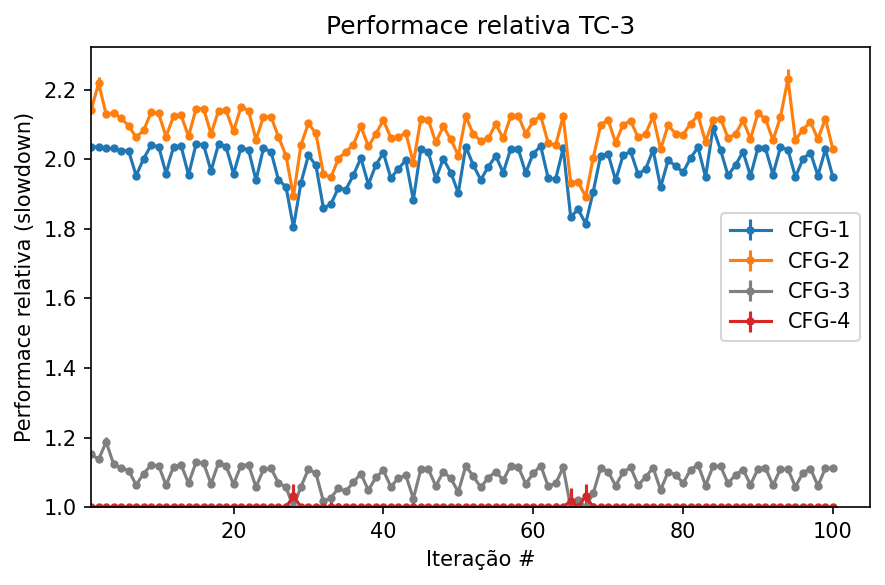

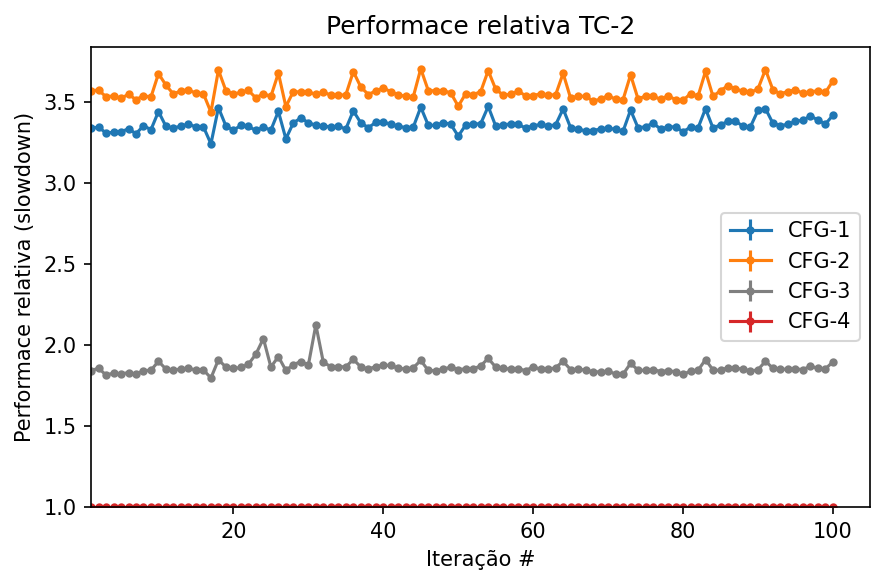

In [4]:
%matplotlib inline

import matplotlib
from statistics import mean,stdev
import matplotlib.pyplot as plt 

lineColor = {
    'CFG-1' :'tab:blue',
    'CFG-2' :'tab:orange',
    'CFG-3' :'tab:gray',
    'CFG-4' :'tab:red',
}

for tc,ccDict in resDict.items():
    plt.figure(figsize=figureSize, dpi= dpiValue, facecolor='w', edgecolor='k')

    resDictMean = {}
    resDictStdD = {}
    for cc in ccDict:
        piTimes = resDict[tc][cc]
        piMeans = list(map(mean, zip(*piTimes)))
        
        if(len(piTimes) == 0):
            continue
    
        # StdDdev = 0 if there is only one run
        if len(piTimes) > 1:
            piStdDev= list(map(stdev, zip(*piTimes)))
            
        else:
            piStdDev=[0]*len(piTimes[0])
        
        resDictMean[cc] = piMeans
        resDictStdD[cc] = piStdDev
        
    
    
    PIs = [pi for cc,pi in resDictMean.items()]
    minTimePIs = list(map(min, zip(*PIs)))
    
    for cc in sorted(ccDict):
        if(len(resDict[tc][cc]) == 0):
            continue
        
    
        relativeValue = [dur/minDur for dur,minDur in zip(resDictMean[cc],minTimePIs)]
        
        xValues=range(1, len(piTimes[0])+1)
        plt.errorbar(xValues, relativeValue, label=f"{cc}", yerr=resDictStdD[cc], 
                     fmt=plotFormat, ecolor=lineColor[cc], c=lineColor[cc],
                     markersize=markerSize)
        

    plt.ylabel("Performace relativa (slowdown)");
    plt.xlabel("Iteração #");
    plt.ylim(1)
    plt.xlim(1)
    plt.title(f"Performace relativa {tc}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'graphs/rel_perf_{tc}.pdf') 
    plt.show()
